
# Statistical comparison of models using grid search

This example illustrates how to statistically compare the performance of models
trained and evaluated using :class:`~sklearn.model_selection.GridSearchCV`.


We will start by simulating moon shaped data (where the ideal separation
between classes is non-linear), adding to it a moderate degree of noise.
Datapoints will belong to one of two possible classes to be predicted by two
features. We will simulate 50 samples for each class:



/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

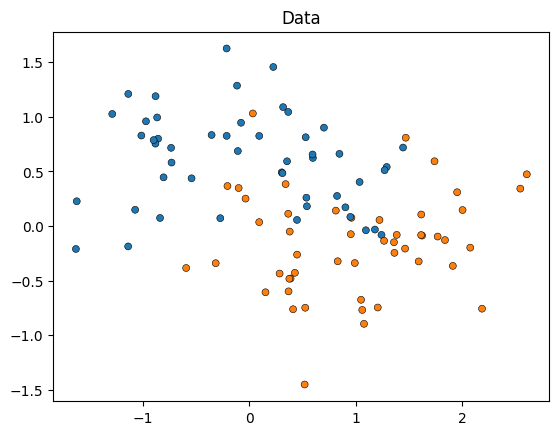

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons

X, y = make_moons(noise=0.352, random_state=1, n_samples=100)

sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=25, edgecolor="k", legend=False
).set_title("Data")
plt.show()

We will compare the performance of :class:`~sklearn.svm.SVC` estimators that
vary on their `kernel` parameter, to decide which choice of this
hyper-parameter predicts our simulated data best.
We will evaluate the performance of the models using
:class:`~sklearn.model_selection.RepeatedStratifiedKFold`, repeating 10 times
a 10-fold stratified cross validation using a different randomization of the
data in each repetition. The performance will be evaluated using
:class:`~sklearn.metrics.roc_auc_score`.



In [2]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC

param_grid = [
    {"kernel": ["linear"]},
    {"kernel": ["poly"], "degree": [2, 3]},
    {"kernel": ["rbf"]},
]

svc = SVC(random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring="roc_auc", cv=cv)
search.fit(X, y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=0),
             estimator=SVC(random_state=0),
             param_grid=[{'kernel': ['linear']},
                         {'degree': [2, 3], 'kernel': ['poly']},
                         {'kernel': ['rbf']}],
             scoring='roc_auc')

We can now inspect the results of our search, sorted by their
`mean_test_score`:



In [3]:
import pandas as pd

results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
rbf,{'kernel': 'rbf'},1,0.9400,0.079297
linear,{'kernel': 'linear'},2,0.9300,0.077846
3_poly,"{'degree': 3, 'kernel': 'poly'}",3,0.9044,0.098776
2_poly,"{'degree': 2, 'kernel': 'poly'}",4,0.6852,0.169106


We can see that the estimator using the `'rbf'` kernel performed best,
closely followed by `'linear'`. Both estimators with a `'poly'` kernel
performed worse, with the one using a two-degree polynomial achieving a much
lower performance than all other models.

Usually, the analysis just ends here, but half the story is missing. The
output of :class:`~sklearn.model_selection.GridSearchCV` does not provide
information on the certainty of the differences between the models.
We don't know if these are **statistically** significant.
To evaluate this, we need to conduct a statistical test.
Specifically, to contrast the performance of two models we should
statistically compare their AUC scores. There are 100 samples (AUC
scores) for each model as we repreated 10 times a 10-fold cross-validation.

However, the scores of the models are not independent: all models are
evaluated on the **same** 100 partitions, increasing the correlation
between the performance of the models.
Since some partitions of the data can make the distinction of the classes
particularly easy or hard to find for all models, the models scores will
co-vary.

Let's inspect this partition effect by plotting the performance of all models
in each fold, and calculating the correlation between models across folds:



/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

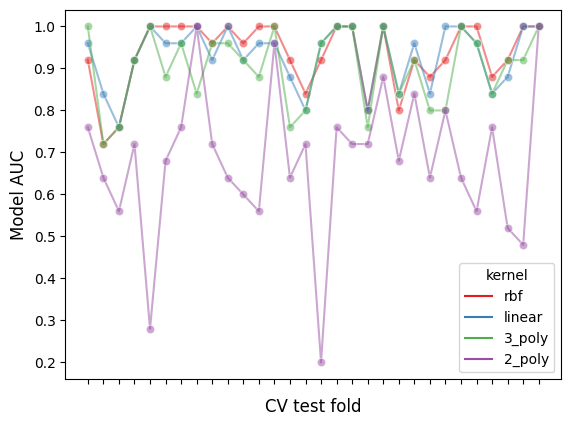

Correlation of models:
 kernel       rbf    linear    3_poly    2_poly
kernel                                        
rbf     1.000000  0.882561  0.783392  0.351390
linear  0.882561  1.000000  0.746492  0.298688
3_poly  0.783392  0.746492  1.000000  0.355440
2_poly  0.351390  0.298688  0.355440  1.000000


In [4]:
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

We can observe that the performance of the models highly depends on the fold.

As a consequence, if we assume independence between samples we will be
underestimating the variance computed in our statistical tests, increasing
the number of false positive errors (i.e. detecting a significant difference
between models when such does not exist) [1]_.

Several variance-corrected statistical tests have been developed for these
cases. In this example we will show how to implement one of them (the so
called Nadeau and Bengio's corrected t-test) under two different statistical
frameworks: frequentist and Bayesian.



## Comparing two models: frequentist approach

We can start by asking: "Is the first model significantly better than the
second model (when ranked by `mean_test_score`)?"

To answer this question using a frequentist approach we could
run a paired t-test and compute the p-value. This is also known as
Diebold-Mariano test in the forecast literature [5]_.
Many variants of such a t-test have been developed to account for the
'non-independence of samples problem'
described in the previous section. We will use the one proven to obtain the
highest replicability scores (which rate how similar the performance of a
model is when evaluating it on different random partitions of the same
dataset) while maintaining a low rate of false positives and false negatives:
the Nadeau and Bengio's corrected t-test [2]_ that uses a 10 times repeated
10-fold cross validation [3]_.

This corrected paired t-test is computed as:

\begin{align}t=\frac{\frac{1}{k \cdot r}\sum_{i=1}^{k}\sum_{j=1}^{r}x_{ij}}
   {\sqrt{(\frac{1}{k \cdot r}+\frac{n_{test}}{n_{train}})\hat{\sigma}^2}}\end{align}

where $k$ is the number of folds,
$r$ the number of repetitions in the cross-validation,
$x$ is the difference in performance of the models,
$n_{test}$ is the number of samples used for testing,
$n_{train}$ is the number of samples used for training,
and $\hat{\sigma}^2$ represents the variance of the observed
differences.

Let's implement a corrected right-tailed paired t-test to evaluate if the
performance of the first model is significantly better than that of the
second model. Our null hypothesis is that the second model performs at least
as good as the first model.



In [5]:
import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [6]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cv.split(X, y))[0][0])
n_test = len(list(cv.split(X, y))[0][1])

t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\nCorrected p-value: {p_val:.3f}")

Corrected t-value: 0.750
Corrected p-value: 0.227


We can compare the corrected t- and p-values with the uncorrected ones:



In [7]:
t_stat_uncorrected = np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(
    f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
    f"Uncorrected p-value: {p_val_uncorrected:.3f}"
)

Uncorrected t-value: 2.611
Uncorrected p-value: 0.005


Using the conventional significance alpha level at `p=0.05`, we observe that
the uncorrected t-test concludes that the first model is significantly better
than the second.

With the corrected approach, in contrast, we fail to detect this difference.

In the latter case, however, the frequentist approach does not let us
conclude that the first and second model have an equivalent performance. If
we wanted to make this assertion we need to use a Bayesian approach.



## Comparing two models: Bayesian approach
We can use Bayesian estimation to calculate the probability that the first
model is better than the second. Bayesian estimation will output a
distribution followed by the mean $\mu$ of the differences in the
performance of two models.

To obtain the posterior distribution we need to define a prior that models
our beliefs of how the mean is distributed before looking at the data,
and multiply it by a likelihood function that computes how likely our
observed differences are, given the values that the mean of differences
could take.

Bayesian estimation can be carried out in many forms to answer our question,
but in this example we will implement the approach suggested by Benavoli and
colleagues [4]_.

One way of defining our posterior using a closed-form expression is to select
a prior conjugate to the likelihood function. Benavoli and colleagues [4]_
show that when comparing the performance of two classifiers we can model the
prior as a Normal-Gamma distribution (with both mean and variance unknown)
conjugate to a normal likelihood, to thus express the posterior as a normal
distribution.
Marginalizing out the variance from this normal posterior, we can define the
posterior of the mean parameter as a Student's t-distribution. Specifically:

\begin{align}St(\mu;n-1,\overline{x},(\frac{1}{n}+\frac{n_{test}}{n_{train}})
   \hat{\sigma}^2)\end{align}

where $n$ is the total number of samples,
$\overline{x}$ represents the mean difference in the scores,
$n_{test}$ is the number of samples used for testing,
$n_{train}$ is the number of samples used for training,
and $\hat{\sigma}^2$ represents the variance of the observed
differences.

Notice that we are using Nadeau and Bengio's corrected variance in our
Bayesian approach as well.

Let's compute and plot the posterior:



In [8]:
# initialize random variable
t_post = t(
    df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
)

Let's plot the posterior distribution:



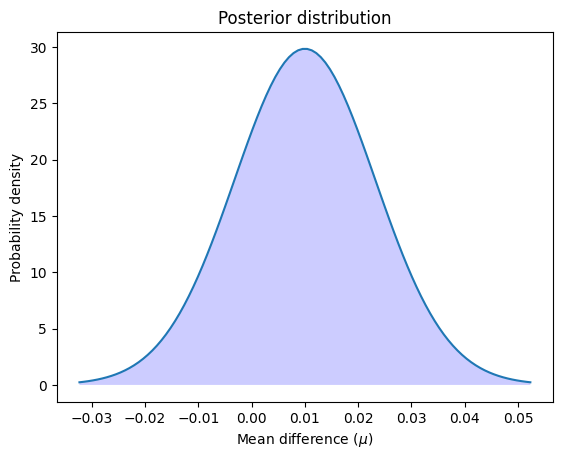

In [9]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.fill_between(x, t_post.pdf(x), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution")
plt.show()

We can calculate the probability that the first model is better than the
second by computing the area under the curve of the posterior distribution
from zero to infinity. And also the reverse: we can calculate the probability
that the second model is better than the first by computing the area under
the curve from minus infinity to zero.



In [10]:
better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_scores.index[0]} being more accurate than "
    f"{model_scores.index[1]}: {better_prob:.3f}"
)
print(
    f"Probability of {model_scores.index[1]} being more accurate than "
    f"{model_scores.index[0]}: {1 - better_prob:.3f}"
)

Probability of rbf being more accurate than linear: 0.773
Probability of linear being more accurate than rbf: 0.227


In contrast with the frequentist approach, we can compute the probability
that one model is better than the other.

Note that we obtained similar results as those in the frequentist approach.
Given our choice of priors, we are essentially performing the same
computations, but we are allowed to make different assertions.



### Region of Practical Equivalence
Sometimes we are interested in determining the probabilities that our models
have an equivalent performance, where "equivalent" is defined in a practical
way. A naive approach [4]_ would be to define estimators as practically
equivalent when they differ by less than 1% in their accuracy. But we could
also define this practical equivalence taking into account the problem we are
trying to solve. For example, a difference of 5% in accuracy would mean an
increase of $1000 in sales, and we consider any quantity above that as
relevant for our business.

In this example we are going to define the
Region of Practical Equivalence (ROPE) to be $[-0.01, 0.01]$. That is,
we will consider two models as practically equivalent if they differ by less
than 1% in their performance.

To compute the probabilities of the classifiers being practically equivalent,
we calculate the area under the curve of the posterior over the ROPE
interval:



In [11]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(
    f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
    f"being practically equivalent: {rope_prob:.3f}"
)

Probability of rbf and linear being practically equivalent: 0.432


We can plot how the posterior is distributed over the ROPE interval:



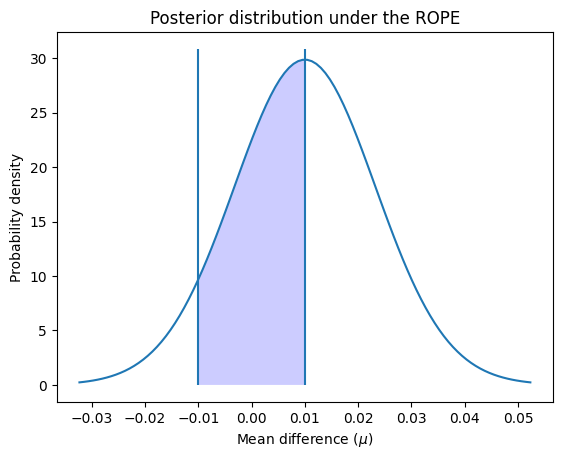

In [12]:
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.01, 0.01], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()

As suggested in [4]_, we can further interpret these probabilities using the
same criteria as the frequentist approach: is the probability of falling
inside the ROPE bigger than 95% (alpha value of 5%)?  In that case we can
conclude that both models are practically equivalent.



The Bayesian estimation approach also allows us to compute how uncertain we
are about our estimation of the difference. This can be calculated using
credible intervals. For a given probability, they show the range of values
that the estimated quantity, in our case the mean difference in
performance, can take.
For example, a 50% credible interval [x, y] tells us that there is a 50%
probability that the true (mean) difference of performance between models is
between x and y.

Let's determine the credible intervals of our data using 50%, 75% and 95%:



In [13]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,0.000977,0.019023
0.75,-0.005422,0.025422
0.95,-0.016445,0.036445


As shown in the table, there is a 50% probability that the true mean
difference between models will be between 0.000977 and 0.019023, 70%
probability that it will be between -0.005422 and 0.025422, and 95%
probability that it will be between -0.016445	and 0.036445.



## Pairwise comparison of all models: frequentist approach

We could also be interested in comparing the performance of all our models
evaluated with :class:`~sklearn.model_selection.GridSearchCV`. In this case
we would be running our statistical test multiple times, which leads us to
the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

There are many possible ways to tackle this problem, but a standard approach
is to apply a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction). Bonferroni can be
computed by multiplying the p-value by the number of comparisons we are
testing.

Let's compare the performance of the models using the corrected t-test:



In [14]:
from itertools import combinations
from math import factorial

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,rbf,linear,0.750,1.000
1,rbf,3_poly,1.657,0.302
2,rbf,2_poly,4.565,0.000
3,linear,3_poly,1.111,0.807
4,linear,2_poly,4.276,0.000
5,3_poly,2_poly,3.851,0.001


In [19]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,...,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,mean_test_score,std_test_score,rank_test_score
kernel,,,,,,,,,,,,,,,,,,,,,
rbf,0.000530,0.000012,0.000796,0.000008,rbf,NaN,{'kernel': 'rbf'},0.92,0.72,0.76,...,0.72,0.92,1.00,0.96,1.00,1.00,0.84,0.9400,0.079297,1
linear,0.000540,0.000030,0.000819,0.000025,linear,NaN,{'kernel': 'linear'},0.96,0.84,0.76,...,0.76,0.92,1.00,0.92,0.92,1.00,0.84,0.9300,0.077846,2
3_poly,0.000538,0.000014,0.000798,0.000009,poly,3,"{'degree': 3, 'kernel': 'poly'}",1.00,0.72,0.76,...,0.68,0.96,1.00,0.96,0.92,1.00,0.56,0.9044,0.098776,3
2_poly,0.000559,0.000013,0.000811,0.000013,poly,2,"{'degree': 2, 'kernel': 'poly'}",0.76,0.64,0.56,...,0.52,0.48,0.68,0.68,0.76,0.84,0.52,0.6852,0.169106,4


We observe that after correcting for multiple comparisons, the only model
that significantly differs from the others is `'2_poly'`.
`'rbf'`, the model ranked first by
:class:`~sklearn.model_selection.GridSearchCV`, does not significantly
differ from `'linear'` or `'3_poly'`.



## Pairwise comparison of all models: Bayesian approach

When using Bayesian estimation to compare multiple models, we don't need to
correct for multiple comparisons (for reasons why see [4]_).

We can carry out our pairwise comparisons the same way as in the first
section:



In [15]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,rbf,linear,0.750,1.000,0.068,0.500,0.432
1,rbf,3_poly,1.657,0.302,0.018,0.882,0.100
2,rbf,2_poly,4.565,0.000,0.000,1.000,0.000
3,linear,3_poly,1.111,0.807,0.063,0.750,0.187
4,linear,2_poly,4.276,0.000,0.000,1.000,0.000
5,3_poly,2_poly,3.851,0.001,0.000,1.000,0.000


Using the Bayesian approach we can compute the probability that a model
performs better, worse or practically equivalent to another.

Results show that the model ranked first by
:class:`~sklearn.model_selection.GridSearchCV` `'rbf'`, has approximately a
6.8% chance of being worse than `'linear'`, and a 1.8% chance of being worse
than `'3_poly'`.
`'rbf'` and `'linear'` have a 43% probability of being practically
equivalent, while `'rbf'` and `'3_poly'` have a 10% chance of being so.

Similarly to the conclusions obtained using the frequentist approach, all
models have a 100% probability of being better than `'2_poly'`, and none have
a practically equivalent performance with the latter.



## Take-home messages
- Small differences in performance measures might easily turn out to be
  merely by chance, but not because one model predicts systematically better
  than the other. As shown in this example, statistics can tell you how
  likely that is.
- When statistically comparing the performance of two models evaluated in
  GridSearchCV, it is necessary to correct the calculated variance which
  could be underestimated since the scores of the models are not independent
  from each other.
- A frequentist approach that uses a (variance-corrected) paired t-test can
  tell us if the performance of one model is better than another with a
  degree of certainty above chance.
- A Bayesian approach can provide the probabilities of one model being
  better, worse or practically equivalent than another. It can also tell us
  how confident we are of knowing that the true differences of our models
  fall under a certain range of values.
- If multiple models are statistically compared, a multiple comparisons
  correction is needed when using the frequentist approach.



.. topic:: References

   .. [1] Dietterich, T. G. (1998). [Approximate statistical tests for
          comparing supervised classification learning algorithms](http://web.cs.iastate.edu/~jtian/cs573/Papers/Dietterich-98.pdf).
          Neural computation, 10(7).
   .. [2] Nadeau, C., & Bengio, Y. (2000). [Inference for the generalization
          error](https://papers.nips.cc/paper/1661-inference-for-the-generalization-error.pdf).
          In Advances in neural information processing systems.
   .. [3] Bouckaert, R. R., & Frank, E. (2004). [Evaluating the replicability
          of significance tests for comparing learning algorithms](https://www.cms.waikato.ac.nz/~ml/publications/2004/bouckaert-frank.pdf).
          In Pacific-Asia Conference on Knowledge Discovery and Data Mining.
   .. [4] Benavoli, A., Corani, G., Demšar, J., & Zaffalon, M. (2017). [Time
          for a change: a tutorial for comparing multiple classifiers through
          Bayesian analysis](http://www.jmlr.org/papers/volume18/16-305/16-305.pdf).
          The Journal of Machine Learning Research, 18(1). See the Python
          library that accompanies this paper [here](https://github.com/janezd/baycomp).
   .. [5] Diebold, F.X. & Mariano R.S. (1995). [Comparing predictive accuracy](http://www.est.uc3m.es/esp/nueva_docencia/comp_col_get/lade/tecnicas_prediccion/Practicas0708/Comparing%20Predictive%20Accuracy%20(Dielbold).pdf)
          Journal of Business & economic statistics, 20(1), 134-144.



In [16]:
n_train

90

In [17]:
n_test

10

/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

LR: 0.773445 (0.044035)
LDA: 0.766969 (0.047966)
KNN: 0.710988 (0.050792)
CART: 0.695437 (0.050385)
NB: 0.759142 (0.038960)
SVM: 0.760458 (0.034712)


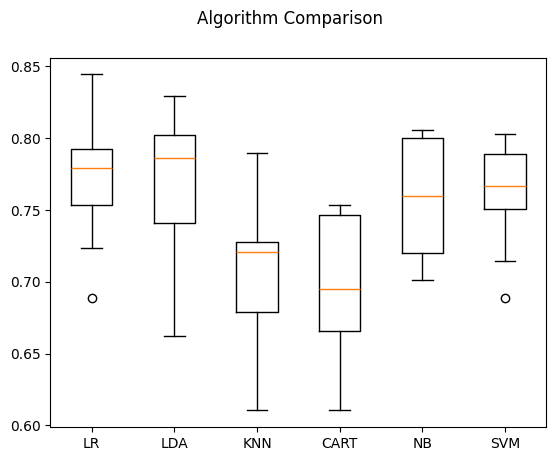

In [18]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

# display(dataframe)


# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()